In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW

# --- PassportHook for DDPM ---

class PassportHook:
    """Hook that applies passport transformation: alpha * output + beta"""

    def __init__(self, conv_layer, passport_activation):
        """
        Args:
            conv_layer: The conv layer module (to get weights)
            passport_activation: Fixed activation from passport [1, C, H, W]
        """
        self.conv_layer = conv_layer
        self.passport_activation = passport_activation.clone()
        self.hook = None

        # Ensure passport is 4D [1, C, H, W]
        if len(self.passport_activation.shape) == 3:
            self.passport_activation = self.passport_activation.unsqueeze(0)

    def compute_alpha_beta(self, output_shape=None):
        """
        Compute alpha and beta using conv weights and passport activation
        alpha = avg(conv(passport_activation))
        beta = avg(conv(passport_activation))
        """
        conv_weights = self.conv_layer.weight

        # Apply convolution: conv(passport_activation)
        conv_result = F.conv2d(
            self.passport_activation,
            conv_weights,
            bias=None,
            stride=self.conv_layer.stride,
            padding=self.conv_layer.padding,
            dilation=self.conv_layer.dilation
        )  # [1, out_channels, H_out, W_out]

        # Compute average pooling
        alpha = torch.mean(conv_result, dim=(2, 3), keepdim=True)  # [1, out_channels, 1, 1]
        beta = torch.mean(conv_result, dim=(2, 3), keepdim=True)

        return alpha, beta

    def hook_fn(self, module, input, output):
        """Apply passport transformation: alpha * output + beta"""
        alpha, beta = self.compute_alpha_beta(output.shape)
        alpha = alpha.to(output.device)
        beta = beta.to(output.device)
        transformed_output = alpha * output + beta
        return transformed_output

    def register(self, module):
        """Register the hook to the module"""
        self.hook = module.register_forward_hook(self.hook_fn)

    def remove(self):
        """Remove the hook"""
        if self.hook:
            self.hook.remove()


# --- Classe Principale Passport DDPM ---

class PassportDDPM:
    def __init__(self, model_id, device="cuda"):
        self.device = device
        self.model_id = model_id

        # Chargement du modele
        self.pipeline = DDPMPipeline.from_pretrained(model_id)
        self.unet = self.pipeline.unet.to(device)
        self.scheduler = self.pipeline.scheduler

        # Configuration par defaut
        self.config = {
            "layer_name": "mid_block.resnets.0.conv1",  # Couche cible (sans .weight)
            "lr": 1e-4,
            "lambda_wat": 1.0,
            "epochs": 5,
            "gamma": 0.1,  # Sign loss parameter
        }

        self.saved_keys = {}

    def _get_layer(self, model, layer_name):
        """Navigate to a layer by its path (e.g., 'mid_block.resnets.0.conv1')"""
        layer = model
        for part in layer_name.split('.'):
            if part.isdigit():
                layer = layer[int(part)]
            else:
                layer = getattr(layer, part)
        return layer

    def _generate_passport_activation(self, model):
        """
        Generate passport activation by running a trigger input through the model
        and capturing the activation at the target layer.
        """
        # Create a fixed trigger input
        trigger_noise = torch.randn(1, 3, 32, 32).to(self.device)
        trigger_timestep = torch.tensor([500], device=self.device).long()

        # Get target layer
        target_layer = self._get_layer(model, self.config["layer_name"])

        # Hook to capture activation
        activation = {}
        def capture_hook(module, input, output):
            activation['output'] = input[0].clone()  # Capture input to this layer

        hook = target_layer.register_forward_hook(capture_hook)

        # Forward pass
        with torch.no_grad():
            _ = model(trigger_noise, trigger_timestep)

        hook.remove()

        return activation['output'], trigger_noise, trigger_timestep

    @staticmethod
    def _sign_loss(watermark, alpha, gamma=0.1):
        """
        Compute sign loss R(P, B) = sum_i max(gamma - alpha_i * b_i, 0)
        Forces alpha signs to match watermark.
        """
        if alpha.dim() > 1:
            alpha = alpha.view(-1)
        watermark = watermark.view(-1)

        if not torch.is_tensor(gamma):
            gamma = torch.tensor(gamma, dtype=alpha.dtype, device=alpha.device)

        values = gamma - alpha * watermark
        R = torch.sum(torch.clamp(values, min=0))
        return R

    @staticmethod
    def _check_sign_match(alpha, watermark):
        """Check how many signs match between alpha and watermark"""
        if alpha.dim() > 1:
            alpha = alpha.view(-1)
        alpha_signs = torch.sign(alpha)
        matches = (alpha_signs == watermark).float()
        accuracy = torch.mean(matches).item()
        return accuracy, alpha_signs

    def embed(self, dataloader):
        """
        Incorpore la marque Passport pendant le finetuning.
        Le watermark est encode dans les signes de alpha.
        """
        print(f"--- Demarrage Embedding Passport ({self.config['layer_name']}) ---")

        # 1. Preparation
        watermarked_unet = self.unet
        watermarked_unet.train()

        # 2. Generate passport activation
        passport_activation, trigger_noise, trigger_timestep = self._generate_passport_activation(watermarked_unet)
        print(f"Passport activation shape: {passport_activation.shape}")

        # 3. Get target layer and create hook
        target_layer = self._get_layer(watermarked_unet, self.config["layer_name"])
        passport_hook = PassportHook(target_layer, passport_activation)

        # 4. Generate watermark (binary {-1, +1})
        out_channels = target_layer.weight.shape[0]
        watermark = torch.randint(0, 2, (out_channels,), dtype=torch.float32).to(self.device) * 2 - 1
        print(f"Watermark size: {len(watermark)} | First 10: {watermark[:10].tolist()}")

        # 5. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_unet.parameters(), lr=self.config["lr"])
        mse_loss = nn.MSELoss()

        gamma = self.config["gamma"]

        # 6. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)
                bs = clean_images.shape[0]

                # A. Processus de Diffusion (Forward)
                noise = torch.randn_like(clean_images).to(self.device)
                timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (bs,), device=self.device).long()
                noisy_images = self.scheduler.add_noise(clean_images, noise, timesteps)

                optimizer.zero_grad()

                # B. Prediction (Task Loss)
                noise_pred = watermarked_unet(noisy_images, timesteps).sample
                l_main = mse_loss(noise_pred, noise)

                # C. Sign Loss (Passport)
                alpha, beta = passport_hook.compute_alpha_beta()
                l_sign = self._sign_loss(watermark, alpha, gamma)

                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_sign

                l_total.backward()
                optimizer.step()

                # Metrics
                sign_acc, alpha_signs = self._check_sign_match(alpha, watermark)
                ber = 1.0 - sign_acc
                pbar.set_description(
                    f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Sign: {l_sign:.3f} | BER: {ber:.2f}"
                )

                if ber == 0.0 and l_sign.item() < 0.01:
                    print("Convergence atteinte !")
                    break
            if ber == 0.0:
                break

        # Sauvegarde des cles
        self.saved_keys = {
            "watermark": watermark,
            "watermarked_unet": watermarked_unet,
            "passport_activation": passport_activation,
            "passport_hook": passport_hook,
            "trigger_noise": trigger_noise,
            "trigger_timestep": trigger_timestep,
        }
        return watermarked_unet

    def extract(self, suspect_unet=None):
        """
        Extrait la marque d'un modele suspect en verifiant les signes de alpha.
        """
        if suspect_unet is None:
            suspect_unet = self.saved_keys["watermarked_unet"]

        watermark = self.saved_keys["watermark"]
        passport_activation = self.saved_keys["passport_activation"]

        # Get target layer from suspect model
        target_layer = self._get_layer(suspect_unet, self.config["layer_name"])

        # Create new hook with same passport activation
        suspect_hook = PassportHook(target_layer, passport_activation)

        # Compute alpha
        with torch.no_grad():
            alpha, beta = suspect_hook.compute_alpha_beta()
            sign_acc, alpha_signs = self._check_sign_match(alpha, watermark)
            ber = 1.0 - sign_acc

        print(f"BER Extrait : {ber:.2f}")
        return ber, alpha_signs

    @staticmethod
    def _compute_ber(alpha_signs, watermark):
        return ((alpha_signs != watermark).float()).mean().item()


/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- EXEMPLE D'EXECUTION ---

# 1. Setup Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Embedding Passport
passport_defense = PassportDDPM("google/ddpm-cifar10-32")
watermarked_model = passport_defense.embed(dataloader)

In [3]:
# 3. Extraction (Test immediat)
ber, _ = passport_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

BER Extrait : 0.00

Resultat final - BER: 0.00


In [4]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_passport(passport_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele Passport vers un modele vierge.
    Verifie si la marque (basee sur les signes de alpha) survit.
    """
    device = passport_obj.device

    # 1. Teacher (Gele)
    teacher_unet = passport_obj.saved_keys["watermarked_unet"]
    teacher_unet.eval()
    for p in teacher_unet.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")
    student_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
    student_unet = student_pipeline.unet.to(device)
    student_unet.train()

    teacher_ber, _ = passport_obj.extract(teacher_unet)
    student_ber, _ = passport_obj.extract(student_unet)
    # Sanity Checks
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    optimizer = AdamW(student_unet.parameters(), lr=lr)
    noise_scheduler = passport_obj.scheduler
    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation Passport ({epochs} epochs) ---")

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)
            bs = clean_images.shape[0]

            # A. Input Noise
            noise = torch.randn_like(clean_images).to(device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # B. Distillation (Output Matching)
            with torch.no_grad():
                target_pred = teacher_unet(noisy_images, timesteps).sample

            student_pred = student_unet(noisy_images, timesteps).sample

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # C. Verification
        current_ber, alpha_signs = passport_obj.extract(student_unet)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER Student: {current_ber:.2f}")

    return student_unet, history


In [5]:
# 4. Attaque par Distillation
student_res, stats = run_distillation_attack_passport(passport_defense, dataloader, epochs=100)

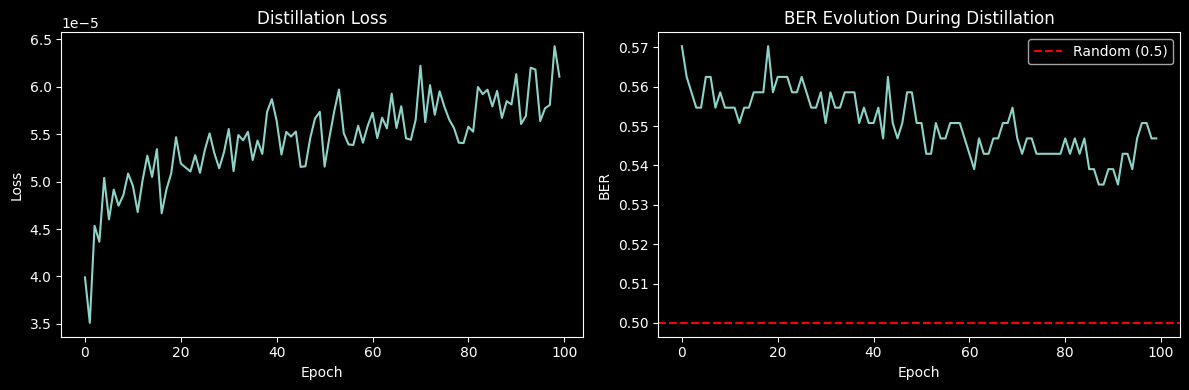

In [6]:
# 5. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

plt.tight_layout()
plt.show()